# pystan for subMM SEDs

Notebook to use `pystan` to sample submm SED models.

### Issues:

* Can I use my getdist (or A Lewis') with this output?
* how do I deal with the mixture model with "duplicate" parameters?
  * currently using `positive ordered` vector of vector of temperatures
* Add optical-depth model


In [2]:
from __future__ import print_function

import os
import sys
import warnings
import cPickle as pickle
import gzip

import pystan

import matplotlib.pyplot as plt
import numpy as np

import getdist

sys.path.append(os.environ['HOME']+'/home/proj/stats/MCMC')
# sys.path.append(os.environ['HOME']+'/home/proj/stats/MCMC/submmSED')

import data

%matplotlib inline

In [39]:
herus_file = "august6table.csv"
speed_of_light = 299792.458 ### micron GHz
d = data.readfluxes_DLC_2014(filename=herus_file)

In [40]:
def makeStanDict(dobj, N_comp=2):
    """ convert from an MCMC object to a dict for input to STAN"""
    return dict(
        N_comp = N_comp,
        N_band = dobj.n,
        nu_obs = dobj.freq_obs,
        flux = dobj.d,
        sigma = dobj.sig,
        z = dobj.z
    )

In [43]:
submm_data = """
    data {

        int<lower=1> N_comp; // number of greybody components (fixed model parameter)

        int<lower=1> N_band;   // number of photometric bands
        vector[N_band] nu_obs; // observed frequency
        vector[N_band] flux;   // observed flux
        vector[N_band] sigma;  // error
        real z;                // redshift
    }
    
    transformed data {
        vector[N_band] nu;     // rest frame frequency
        nu <- (1+z)*nu_obs;    // could do this outside of stan...
    }
    
"""

submm_functions = """
    functions {
        
        real greybody(real beta, real T, real nu) {
          // greybody, normalized to unit flux at nu=nu_0
            real h_over_k;
            real x;
            real nu_0;
            real x_0;
            
            nu_0 <- 1000;

            h_over_k <- 0.04799237;       //  K/Ghz
            x <- h_over_k * nu / T;
            x_0 <- h_over_k * nu_0 / T;
            return (pow(nu/nu_0, 3+beta) * expm1(x_0) / expm1(x));
        }
    }
"""

submm_model_greybody_1 = """
    // single-component greybody -- not used
    parameters {
        real amplitude<lower=0.0>;
        real T<lower=3, upper=100.0>; // Temperature in K
        real beta<lower=0, upper=3>;  // greybody factor
    }
    
    transformed parameters {
        real totalflux<lower=0>[N_band];
        for (band in 1:N_band)
            totalflux[band] <- amplitude * greybody(beta, T, nu[band])
    }
    
    model {
        // no explicit priors on parameters -- improper... 
        flux ~ normal(totalflux, sigma)
    }
    
"""

submm_model_greybody = """
    parameters {
    // nb. N_comp, N_band are data
//        vector[N_comp] log10amplitude;
        vector<lower=0>[N_comp] amplitude;
//          vector<lower=3, upper=100.0>[N_comp] T; // Temperature in K  
        positive_ordered[N_comp] T;
        vector<lower=0, upper=3>[N_comp] beta;  // greybody factor    
    }
    
// not used, since this is only needed if you want to keep track of these parameters.
//    transformed parameters {
//        real<lower=0> fluxes[N_band, N_comp];
//        real<lower=0> totalflux[N_band];
//        real<lower=0> amplitude[N_comp];
//        
//        for (comp in 1:N_comp)
//            amplitude[comp] <- pow(10.0, log10amplitude[comp]);
//        
//        for (band in 1:N_band) {
//            for (comp in 1:N_comp) {  // vectorize over this?
//                fluxes[band, comp] <- amplitude[comp] * greybody(beta[comp], T[comp], nu[band]);
//            }
//           totalflux[band] <- sum(fluxes[band]);
//        }
//    }
    
    model {
        real fluxes[N_band, N_comp];
        vector[N_band] totalflux;
//        vector[N_comp] amplitude;
        
//        for (comp in 1:N_comp)
//            amplitude[comp] <- pow(10.0, log10amplitude[comp]);
        
        for (band in 1:N_band) {
            for (comp in 1:N_comp) {  // vectorize over this?
                fluxes[band, comp] <- amplitude[comp] * greybody(beta[comp], T[comp], nu[band]);
            }
            totalflux[band] <- sum(fluxes[band]);
        }

        // try a proper prior on temperature; needed since ordered vectors don't have limits
        for (comp in 1:N_comp) {
            T[comp] ~ uniform(0,100);
        }
        flux ~ normal(totalflux, sigma);
    }
    
"""


submm_model_greybody_b2 = """

//// like submm_model_greybody, but with fixed beta=2 
    parameters {
    // nb. N_comp, N_band are data
        vector<lower=0>[N_comp] amplitude;
//          vector<lower=3, upper=100.0>[N_comp] T; // Temperature in K  
        positive_ordered[N_comp] T;
    }

    model {
        real fluxes[N_band, N_comp];
        vector[N_band] totalflux;

        for (band in 1:N_band) {
            for (comp in 1:N_comp) {
                fluxes[band, comp] <- amplitude[comp] * greybody(2.0, T[comp], nu[band]);
            }
            totalflux[band] <- sum(fluxes[band]);
        }

        // try a proper prior on temperature; needed since ordered vectors don't have limits
        for (comp in 1:N_comp) {
            T[comp] ~ uniform(0,100);
        }
        flux ~ normal(totalflux, sigma);
    }
    
"""

In [44]:
greybody_code = submm_functions + submm_data + submm_model_greybody
greybody_model = pystan.StanModel(model_code=greybody_code, model_name="greybody")
greybody_b2_code = submm_functions + submm_data + submm_model_greybody_b2
greybody_b2_model = pystan.StanModel(model_code=greybody_b2_code, model_name="greybody_beta2")

In [61]:
obj=np.where([dd.name=="IRAS20414-1651" for dd in d])[0][0]
print(obj)
dobj = d[obj]
N_comp = 2
print(d[obj].name)

fit = greybody_b2_model.sampling(data=makeStanDict(d[obj], N_comp=N_comp),
                  iter=10000, chains=4)


28
IRAS20414-1651


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing

[u'amplitude', u'T', u'lp__']
(5000, 4, 5)
[u'amplitude', u'T']
(20000, 2)
[(20000,), (20000,)]
Inference for Stan model: greybody_beta2_21a20e09c3a613a20adeeddd8863ecf9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
amplitude[0]   0.54  1.0e-3   0.04   0.45   0.52   0.55   0.57    0.6 1287.0    1.0
amplitude[1]    0.1  1.1e-3   0.04   0.05   0.07   0.09   0.12   0.19 1287.0    1.0
T[0]          25.56    0.02   0.84  23.69  25.03  25.65  26.16  26.97 1499.0    1.0
T[1]          49.93    0.12   4.64  41.89  46.49  49.65  52.98   59.8 1429.0    1.0
lp__          -4.93    0.03   1.39  -8.45  -5.58  -4.62  -3.91  -3.22 2856.0    1.0

Samples were drawn using NUTS(diag_e) at Thu Aug 20 09:56:09 2015.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (

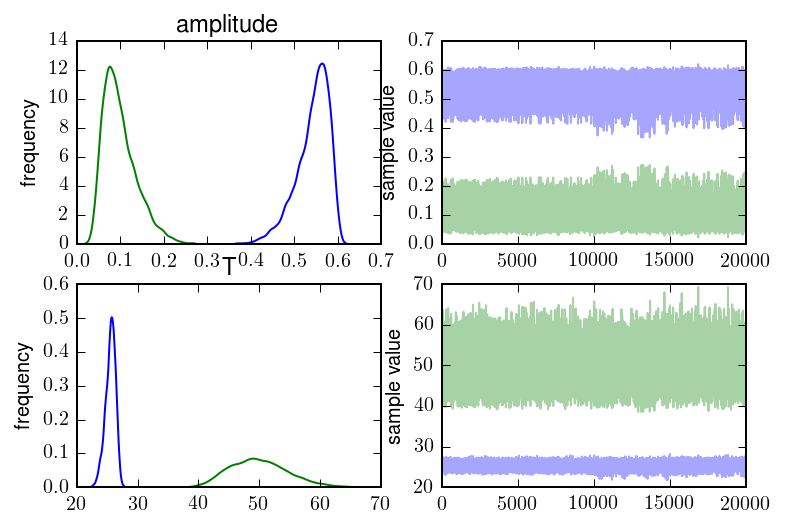

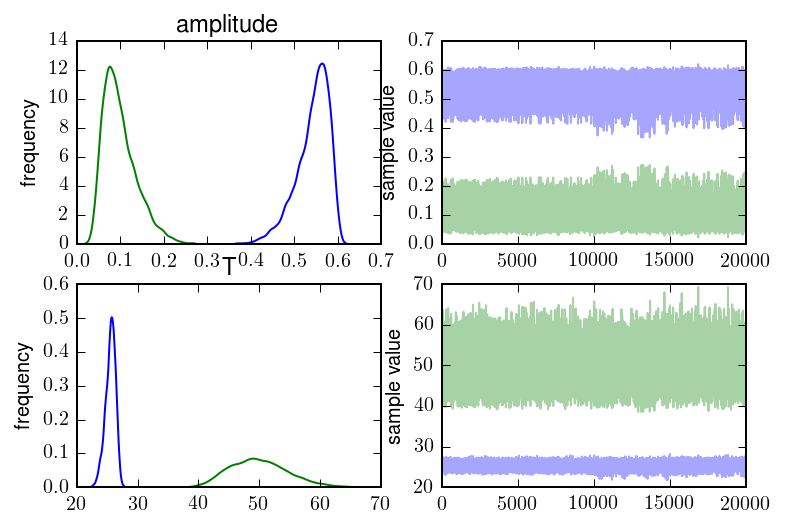

In [62]:
print(fit.extract(permuted=True).keys())
print(fit.extract(permuted=False).shape)
print(fit.model_pars)
print(fit.extract(permuted=True)['amplitude'].shape)
print([a.shape for a in fit.extract(permuted=True)['amplitude'].T])
print(fit)
fit.plot()

In [47]:
fits = {}
niter = 10000
nchains = 4
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for dobj in d:
        print(dobj.name)
        fits[dobj.name] = []
        for n_comp in (1,2):
            fit_beta = greybody_model.sampling(data=makeStanDict(dobj, N_comp=n_comp),
                                        iter=niter, chains=nchains)
            fits[dobj.name].append(fit_beta)
            try:
                print(fit_beta)
            except OverflowError:
                print("Can't print! %s %d unconstrained beta" % (dobj.name, n_comp))

            fit_b2 = greybody_b2_model.sampling(data=makeStanDict(dobj, N_comp=n_comp),
                                        iter=niter, chains=nchains)
            fits[dobj.name].append(fit_b2)
            try:
                print(fit_b2)
            except OverflowError:
                print("Can't print! %s %d beta=2"  % (dobj.name, n_comp))



IRAS00188-0856
Inference for Stan model: greybody_62ed89537f2de8a0302771c2118de22b.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
amplitude[0]   0.38  5.4e-5 3.2e-3   0.38   0.38   0.38   0.39   0.39 3511.0    1.0
T[0]           35.1    0.02   1.08  32.96  34.38  35.11  35.82  37.23 3102.0    1.0
beta[0]        1.73  1.1e-3   0.06   1.62   1.69   1.73   1.77   1.85 2939.0    1.0
lp__          -10.0    0.02   1.19 -13.09 -10.54  -9.69  -9.12  -8.63 3333.0    1.0

Samples were drawn using NUTS(diag_e) at Wed Aug 19 16:04:59 2015.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: greybody_beta2_1dbccaaf2b16ec8ec87279bc6af8951f.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draw

In [49]:
with gzip.open("greybody_model_stan.pkl.gz", "wb") as f:
    pickle.dump(greybody_model, f)
with gzip.open("greybody_b2_model_stan.pkl.gz", "wb") as f:
    pickle.dump(greybody_b2_model, f)
with gzip.open("greybody_fits_stan.pkl.gz", "wb") as f:
    pickle.dump(fits, f)



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/pickle.py:306: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  rv = reduce(self.proto)


In [50]:
def pystan2getdist(fit, texdict={}):
    """ convert a pystan fit object into an A Lewis MCSamples object
        texdict is a dictionary mapping from stan parameter names to latex labels, if desired
    """
    
    ### have to either deal with combining chains (permute=False) 
    ###                       or separating vector-valued parameters (permute=True)
    
    sample_dict = fit.extract(permuted=True)
    names = []
    labels = []
    samples = []
    for par, samps in sample_dict.iteritems():
        if par == "lp__":
            loglikes = -samps
        else:
            if len(samps.shape)==1:
                names.append(par)
                labels.append(par)
                samples.append(samps)
            else:
                for i,s in enumerate(samps.T):
                    samples.append(s)
                    names.append(par+str(i+1))
                    
                    labels.append(texdict.get(par,par)+"_"+str(i+1))
    
    return getdist.MCSamples(names=labels, samples=samples, loglikes=loglikes, labels=labels)

In [ ]:
gds = {}
texdict={"amplitude": "A", "beta": "\beta"}
for obj, fs in fits.iteritems():
    gds[obj] = [pystan2getdist(f, texdict) for f in fs]
### order is 1comp, 2comp, 1compb2, 2compb2
    
with gzip.open("greybody_getdist.pkl.gz", "wb") as fil:
    pickle.dump(gds, fil)

        
    

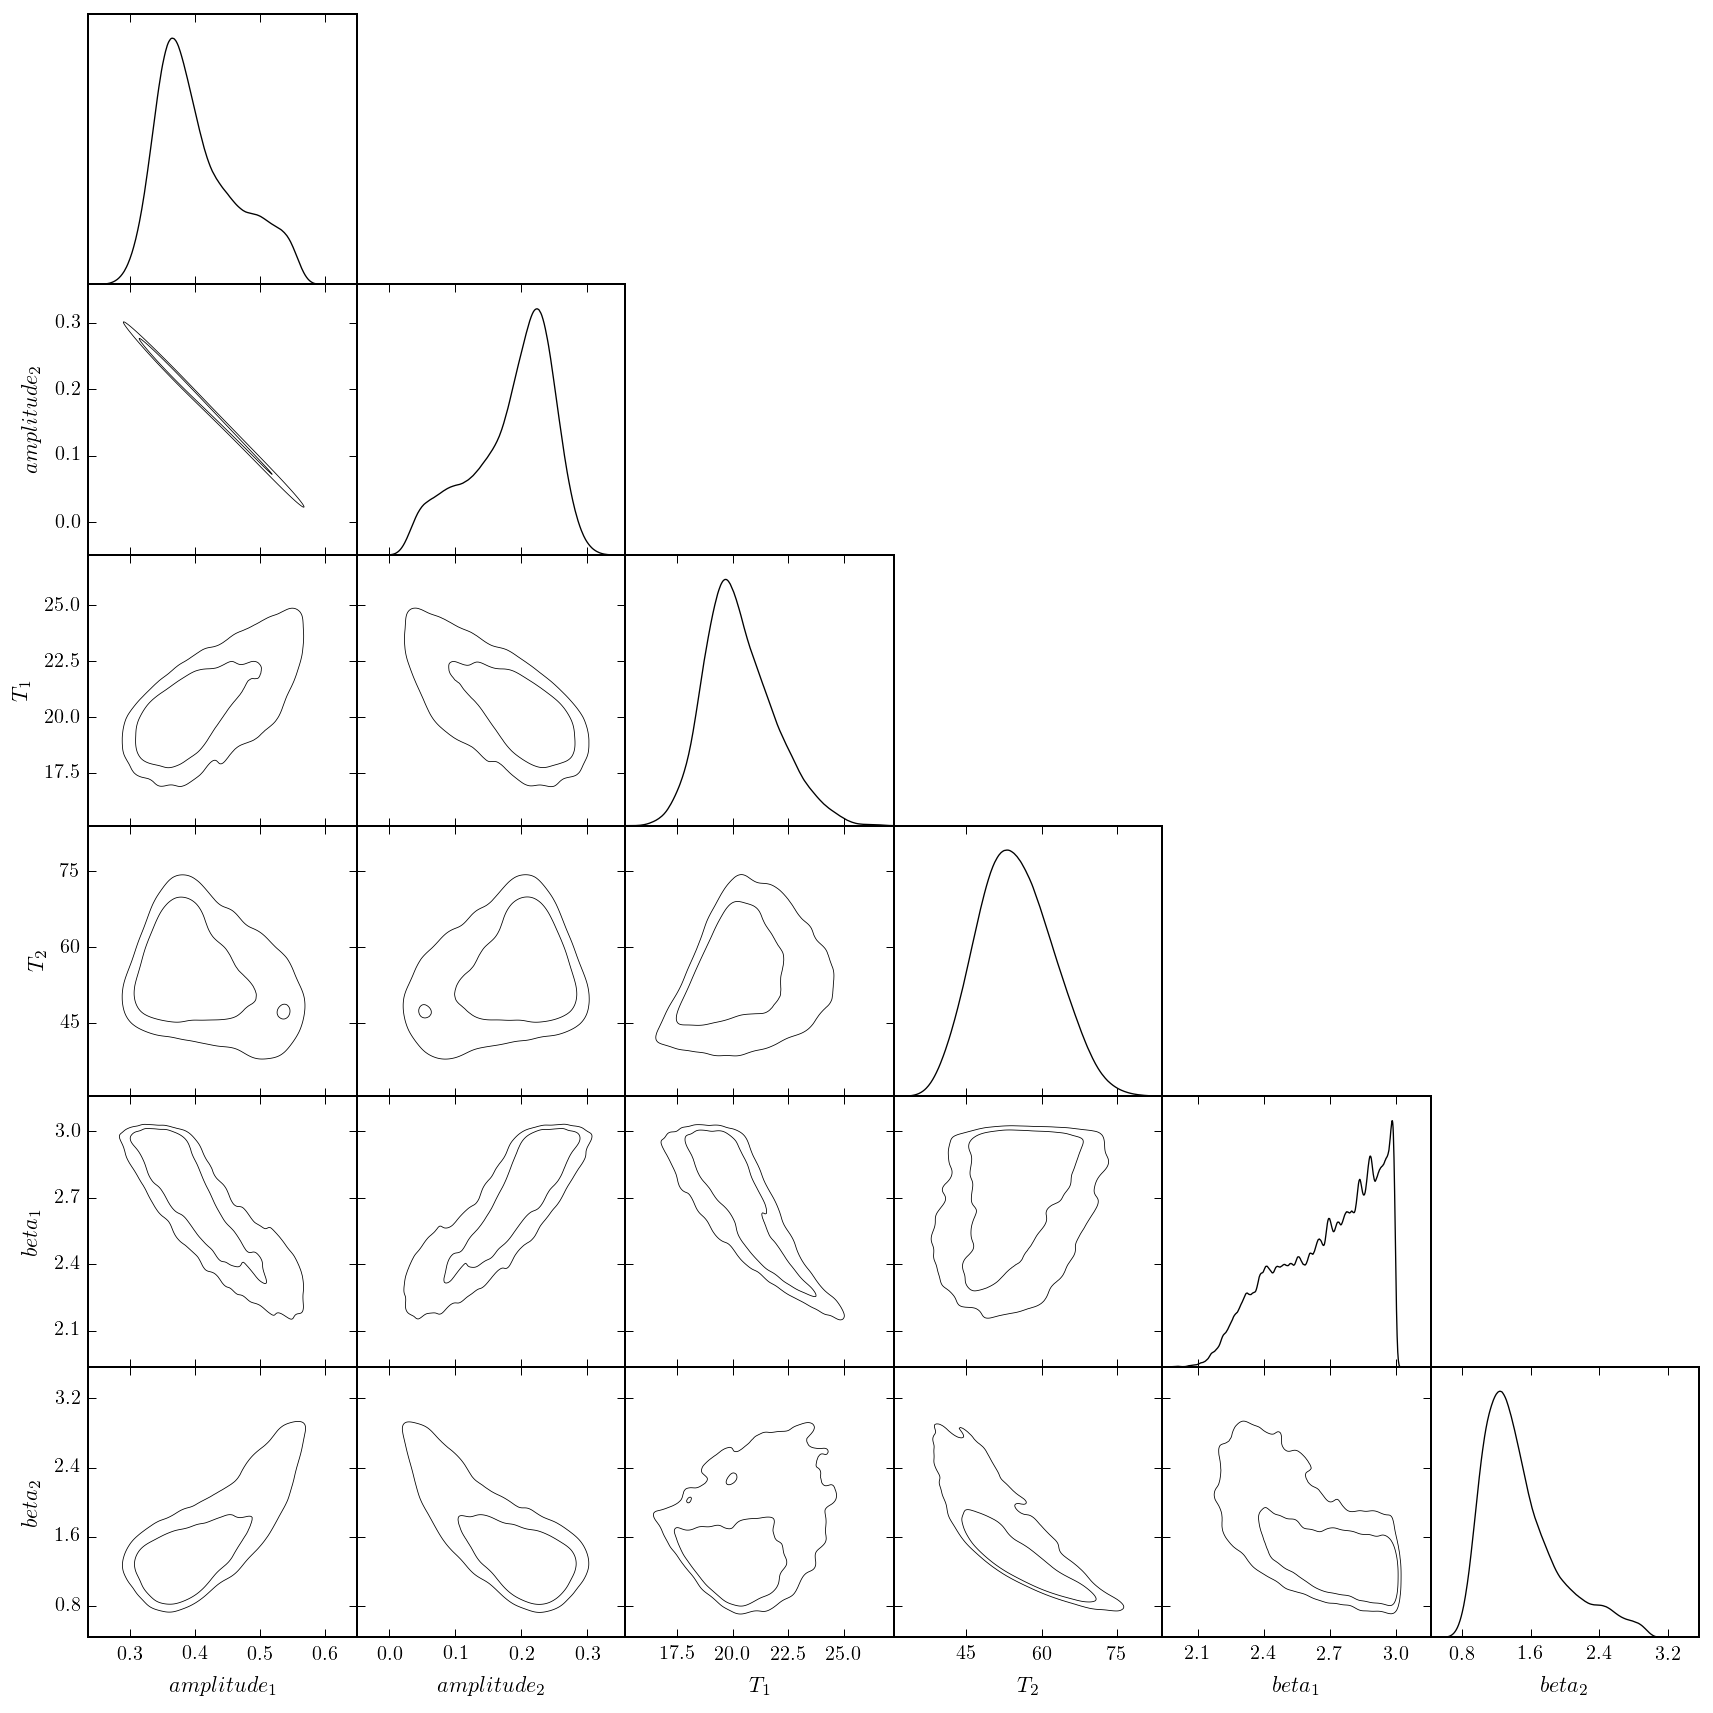

In [46]:
import getdist.plots
gd = pystan2getdist(fit)
g = getdist.plots.getSubplotPlotter()
g.triangle_plot(gd)

In [6]:
with gzip.open("greybody_getdist.pkl.gz", "rb") as f:
    gds = pickle.load(f)

In [17]:
import getdist.plots
g = getdist.plots.getSubplotPlotter()

obj = gds.keys()[1]
print(obj)
stop
for gd in gds[obj]:
    g.triangle_plot(gd)

IRAS20414-1651


NameError: name 'stop' is not defined

In [15]:
texdict={"amplitude": "A"}
par = "amplitude"
texdict.get(par,par)

'A'

In [18]:
gd = gds[obj][3]

In [36]:
gd.paramNames?